In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')


sns.set(style='white',context='notebook',palette='deep')

# Load and check data

## load data

In [2]:
dir = 'C:/Users/rsh15/Desktop/seunghuni/dataset/titanic'
train = pd.read_csv(dir+'/train.csv')
test  = pd.read_csv(dir+'/test.csv')

## outlier detection

In [3]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing
    more than n outliers according to the Tukey method.
    """
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile(25%)
        Q1 = np.percentile(df[col],25)
        
        # 3rd quartile(75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile range(IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)
    
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# detect outliers from age, sibsp, parch and fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp",'Parch','Fare'])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


## join train and test set

In [5]:
# Drop Outliers
train = train.drop(Outliers_to_drop,axis=0).reset_index(drop=True)

In [6]:
# join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat([train,test],axis=0).reset_index(drop=True)

## check for null and missing values

In [7]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for null values
# Age and Cabin features have an important part of missing values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
# infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# summarise data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature Analysis

## Numerical Values

<Figure size 1296x720 with 0 Axes>

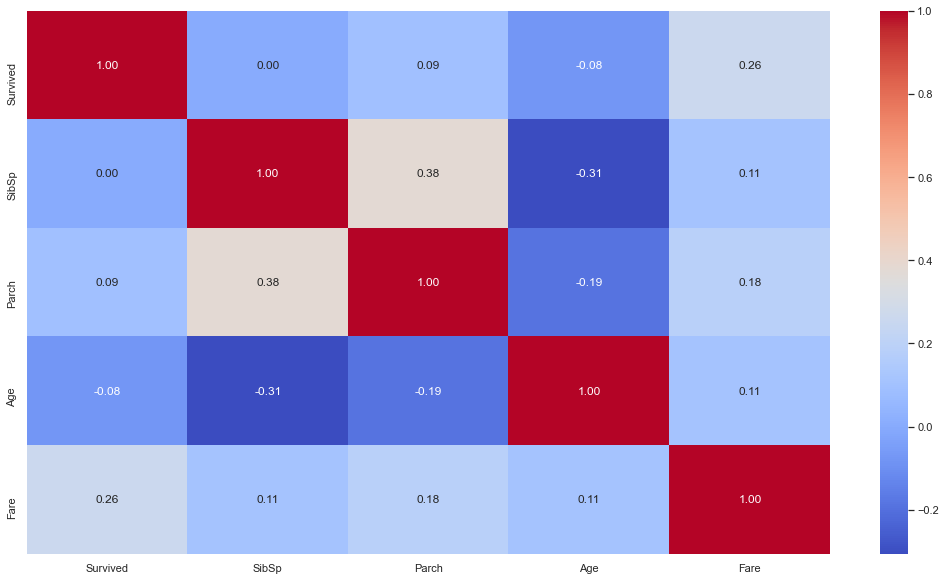

In [12]:
# correlation matrix between numerical values (sibsp parch age and fare values) and survived
plt.figure(figsize=(18,10))
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt='.2f',cmap='coolwarm')

In [13]:
# only fare seems to have a significative correlation with the survival probability
# it doesnt mean that the other features are not usefull.
# subpopulations in these features can be correlated with the survival.
# to determine this, we need to explore in detail these features

### sibsp

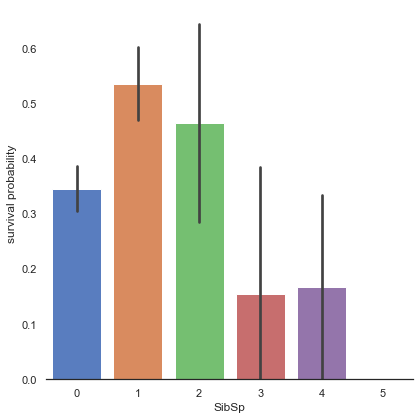

In [14]:
# explore sibsp feature vs survived
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

In [15]:
# it seems that passengers having a lot of siblings/spouses have less chance to survive
# single passengers or with two other persons have more chance to survive

### parch

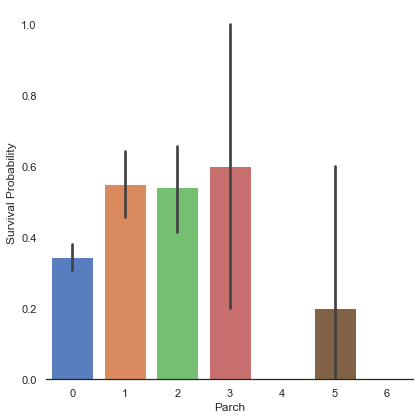

In [16]:
# explore parch feature vs survived
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival Probability')

In [17]:
# small families have more chance to survive,d more than single(parch=0), medium(parch=3,4) and large(parch=5,6) families
# becareful there is an important standard deviation in the survival of passengers with 3 parents/children

### Age

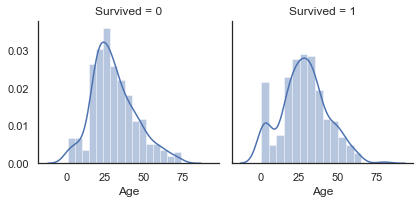

In [18]:
# explore age vs survived
g = sns.FacetGrid(train,col = 'Survived')
g = g.map(sns.distplot,'Age')

In [19]:
# age distribution seems to be tailed distribution, maybe a gaussian distribution
# we note age distributions are not the same in the survived and not survived.
# indeed, there is a peak corresponding to young passengers, that have survived.
# we also see that passengers between 60-80 have less survived
# so, even if age is not correlated with survived, we can see that there is age categories of passengers that of have
# more or less chance to survive

<AxesSubplot:>

<AxesSubplot:>

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Frequency')

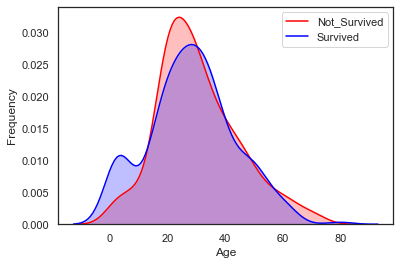

In [20]:
sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())],color='Red',shade=True)
sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())],color='Blue',shade=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(['Not_Survived','Survived'])

In [21]:
# superimpose the two densities, we clearly see a peak corresponding (between 0,5) to babies and very young childrens

### Fare

In [22]:
dataset['Fare'].isnull().sum()

1

In [23]:
# fill fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

In [24]:
# since we have one missing value, i decided to fill it with the median value which will not have an important effect
# on the prediction

<Figure size 1296x576 with 0 Axes>

<AxesSubplot:xlabel='Fare'>

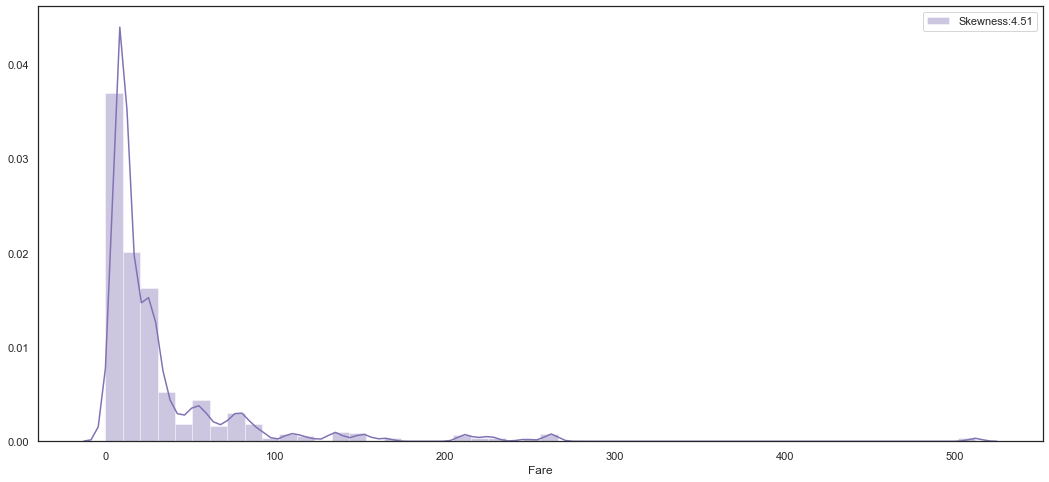

In [25]:
# explore fare distribution
plt.figure(figsize=(18,8))
sns.distplot(dataset['Fare'],color='m',label='Skewness:%.2f'%(dataset['Fare'].skew()))
plt.legend(loc='best')

In [26]:
# as we can see, fare distribution is very skewed.
# this can lead to overweight very high values in the model, even if its scaled.
# in this case, its better to transform it with the log function to reduce this skew

In [27]:
# apply log to fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i:np.log(i) if i > 0 else 0)

<Figure size 1296x576 with 0 Axes>

<AxesSubplot:xlabel='Fare'>

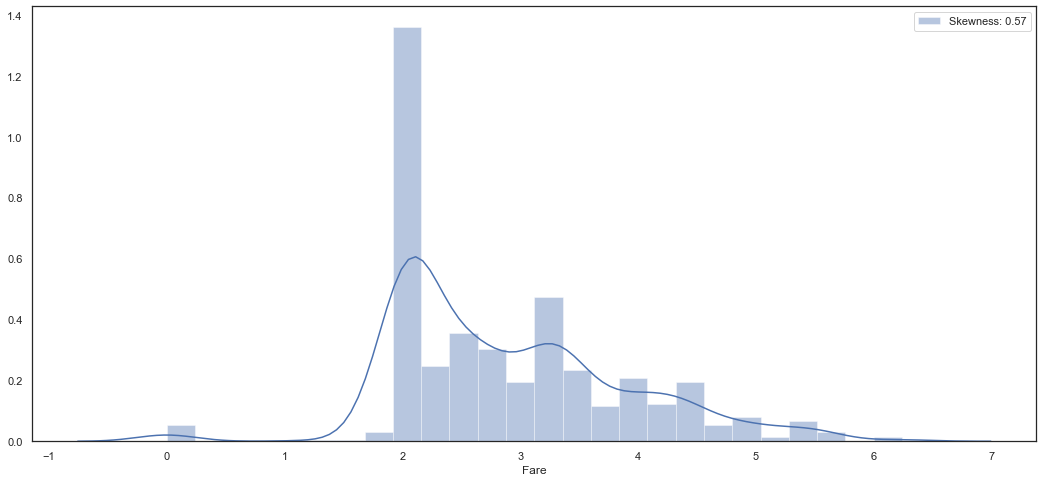

In [28]:
plt.figure(figsize=(18,8))
sns.distplot(dataset['Fare'],color='b',label='Skewness: %.2f'%(dataset['Fare'].skew()))
plt.legend(loc='best')

In [29]:
# skewness is clearly reduced after the log transformation.

## Categorical values

### sex

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

Text(0, 0.5, 'Survival Probability')

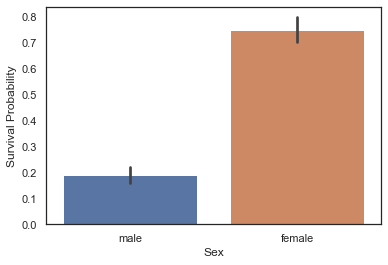

In [30]:
sns.barplot(x='Sex',y='Survived',data=train)
plt.ylabel('Survival Probability')

In [31]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [32]:
# it is clearly obvious that male have less chance to survive than female
# so sex, might play an important role in the prediction of the survival
# "Women and children first"

### pclass

Text(8.96, 0.5, 'Survival Probability')

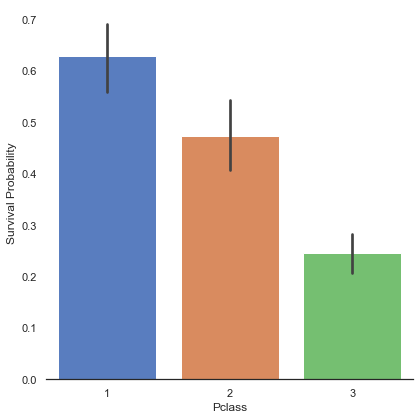

In [33]:
sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',size=6,palette='muted')
sns.despine(left=True)
plt.ylabel('Survival Probability')

Text(31.70115682870371, 0.5, 'survival probability')

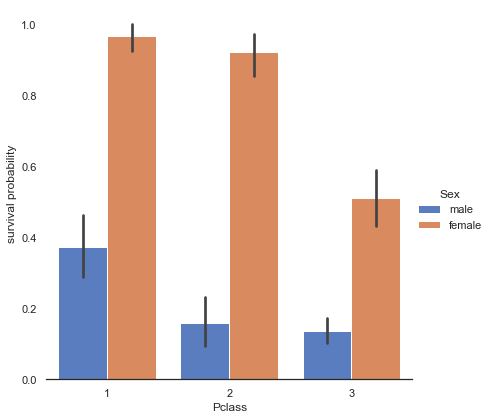

In [34]:
# explore Pclass vs Survived by sex
sns.factorplot(x='Pclass',y='Survived',hue='Sex',data=train,size=6,kind='bar',palette='muted')
sns.despine(left=True)
plt.ylabel('survival probability')

### embarked

In [35]:
dataset['Embarked'].isnull().sum()

2

In [36]:
# fill embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset['Embarked'].fillna('S')

In [37]:
# since we have two missing values, i decided to fill them with the most frequent value of embarked

Text(8.96, 0.5, 'survival probability')

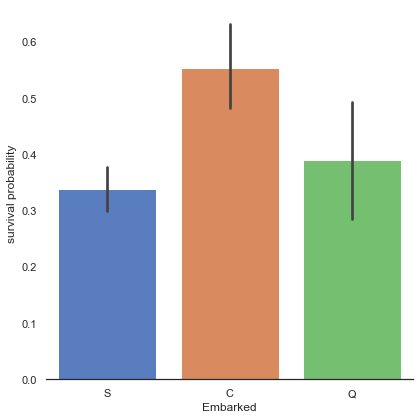

In [38]:
# explore embarked vs Survived
sns.factorplot('Embarked','Survived',data=train,size=6,kind='bar',palette='muted')
sns.despine(left=True)
plt.ylabel('survival probability')

Text(877.7366666666668, 0.5, 'Count')

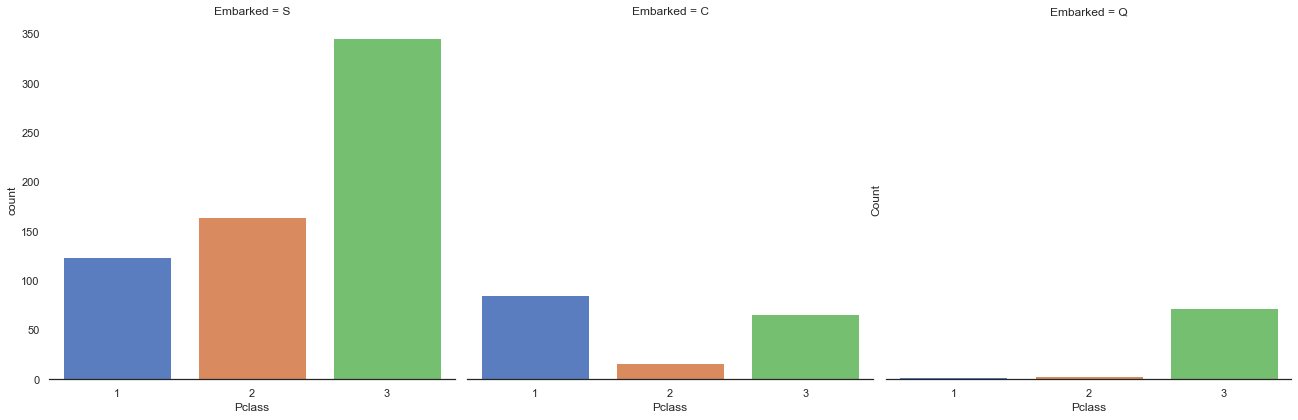

In [39]:
sns.factorplot("Pclass",col="Embarked",data=train,
               size=6,kind='count',palette='muted')
sns.despine(left=True)
plt.ylabel('Count')

In [40]:
# Indeed, the third class is the most frequent for passenger coming from S and Q 
# whereas C Passengers are mostly in first class which have the highest survival rate
# at this point, i cant explain why first class has an higher survival rate
# my hypothesis is that first class passengers were prioritised during the evacuation due to their influence

# Filling Missing Values

## age

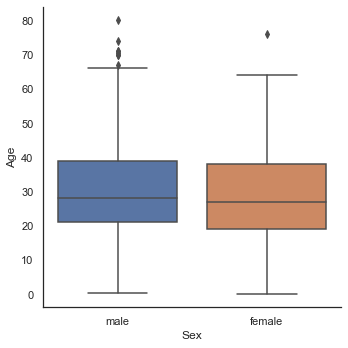

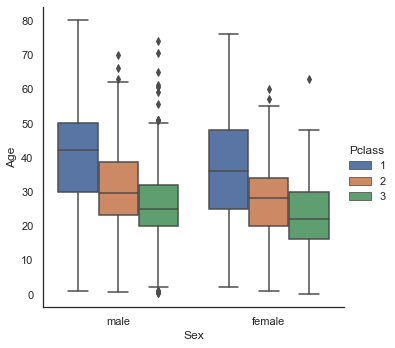

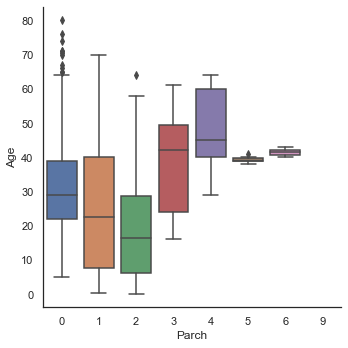

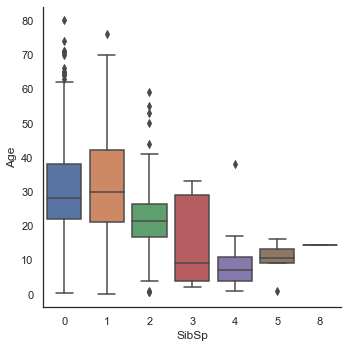

In [41]:
sns.factorplot(y='Age',x='Sex',data=dataset,kind='box')
sns.factorplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
sns.factorplot(y='Age',x='Parch',data=dataset,kind='box')
sns.factorplot(y='Age',x='SibSp',data=dataset,kind='box')

In [42]:
# convert sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})

<Figure size 1296x576 with 0 Axes>

<AxesSubplot:>

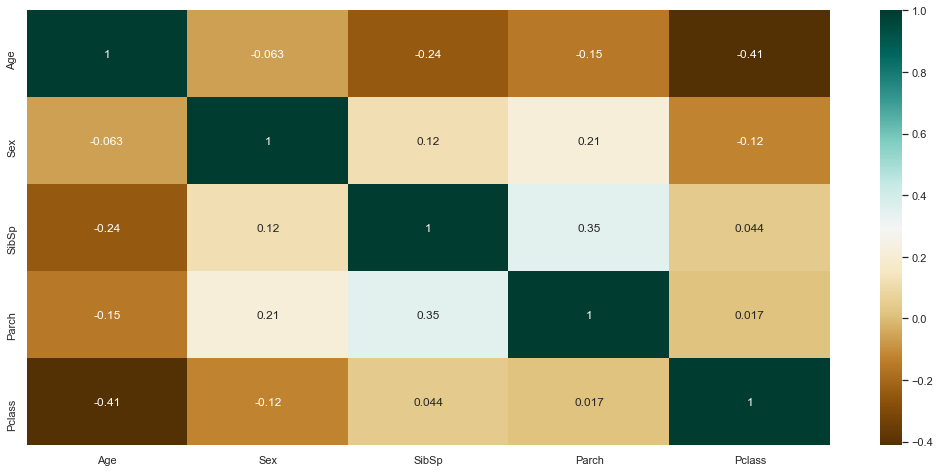

In [43]:
plt.figure(figsize=(18,8))
sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

In [44]:
# filling missing value of age
## fill age with the median age of similar rows according to Pclass, Parch, SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) &
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

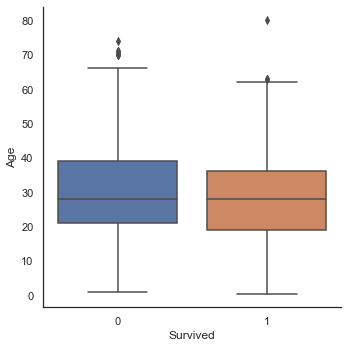

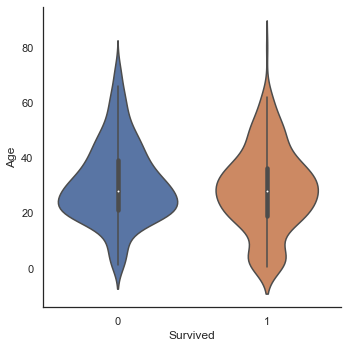

In [45]:
sns.factorplot(x='Survived',y='Age',data=train,kind='box')
sns.factorplot(x='Survived',y='Age',data=train,kind='violin')

# feature engineering

## name/title

In [46]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [47]:
# get title from name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

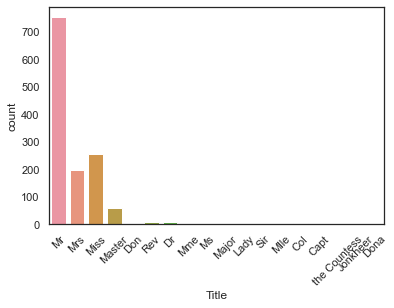

In [48]:
g = sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

In [49]:
# convert to categorical values title
dataset['Title'] = dataset['Title'].replace(['Lady','the Countess','Countess','Capt','Col','Don','Dr','Major','Rev',
                                             'Sir','Jonkheer','Dona'],'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0,'Miss':1,'Ms':1,'Mme':1,'Mlle':1,'Mrs':1,'Mr':2,'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

<AxesSubplot:xlabel='Title', ylabel='count'>

([<matplotlib.axis.XTick at 0x2202f9d9910>,
 [Text(0, 0, 'Master'),
  Text(1, 0, 'Miss-Mrs'),
  Text(2, 0, 'Mr'),
  Text(3, 0, 'Rare')])

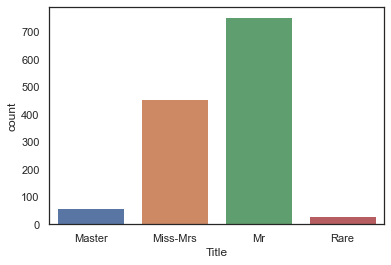

In [50]:
sns.countplot(dataset['Title'])
plt.xticks([0,1,2,3],labels=['Master','Miss-Mrs','Mr','Rare'])

([<matplotlib.axis.XTick at 0x2202fa2a0d0>,
 [Text(0, 0, 'Master'),
  Text(1, 0, 'Miss_Mrs'),
  Text(2, 0, 'Mr'),
  Text(3, 0, 'Rare')])

Text(8.96, 0.5, 'Survival Probability')

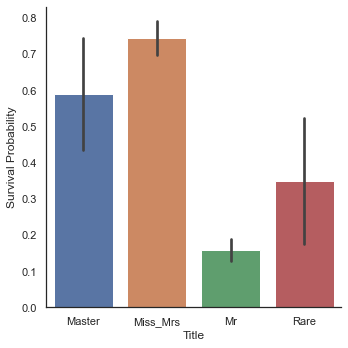

In [51]:
sns.factorplot(x='Title',y='Survived',data=dataset,kind='bar')
plt.xticks([0,1,2,3],['Master','Miss_Mrs','Mr','Rare'])
plt.ylabel('Survival Probability')

In [52]:
# drop name variable
dataset.drop(labels=['Name'],axis=1,inplace=True)

### Family Size

In [53]:
# create a family size descriptor from sibsp and parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

Text(8.96, 0.5, 'Survival Probability')

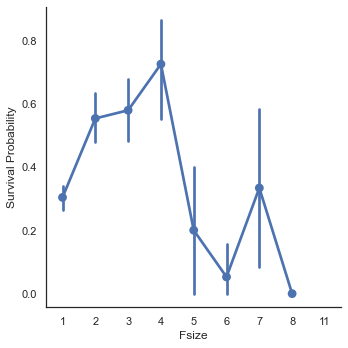

In [54]:
sns.factorplot(x='Fsize',y='Survived',data=dataset)
plt.ylabel('Survival Probability')

In [55]:
# the family size seems to play an important role, survival probability is worst for large families
# additionally i decided to create 4 categories of family size

In [56]:
# create new feature of familysize
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['smallf'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['medf']   = dataset['Fsize'].map(lambda s: 1 if 3 <= s <=4 else 0)
dataset['largef'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

Text(8.96, 0.5, 'Survival Probability')

Text(8.96, 0.5, 'Survival Probability')

Text(8.96, 0.5, 'Survival Probability')

Text(8.96, 0.5, 'Survival Probability')

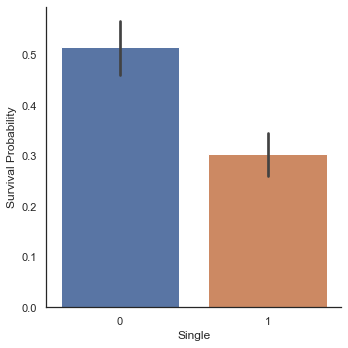

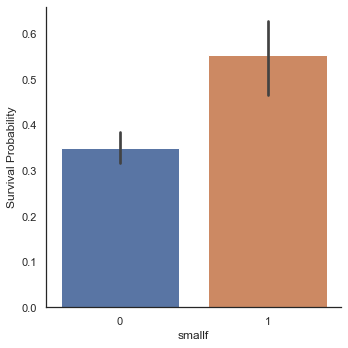

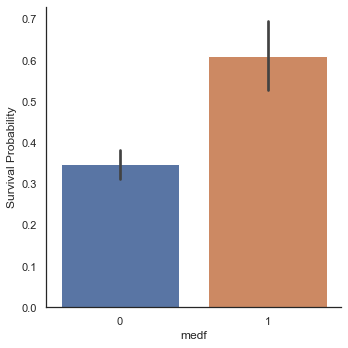

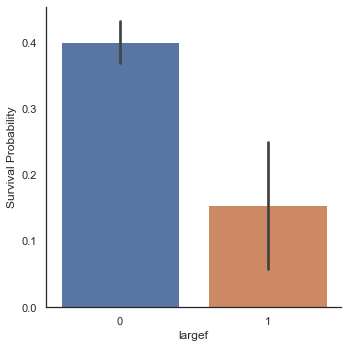

In [57]:
sns.factorplot(x='Single',y='Survived',data=dataset,kind='bar')
plt.ylabel('Survival Probability')

sns.factorplot(x='smallf',y='Survived',data=dataset,kind='bar')
plt.ylabel('Survival Probability')

sns.factorplot(x='medf',y='Survived',data=dataset,kind='bar')
plt.ylabel('Survival Probability')

sns.factorplot(x='largef',y='Survived',data=dataset,kind='bar')
plt.ylabel('Survival Probability')

In [58]:
# factorplots of familysize categories show that small and medium families have more chance to survive
# than single passenger and large families

In [59]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset,columns=['Title'])
dataset = pd.get_dummies(dataset,columns=['Embarked'],prefix='Em')

In [60]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,smallf,medf,largef,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### cabin

In [61]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [62]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [63]:
dataset['Cabin'].isnull().sum()

1007

In [64]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [65]:
# replace the cabin number by the type of cabin x if not
dataset['Cabin'] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'])

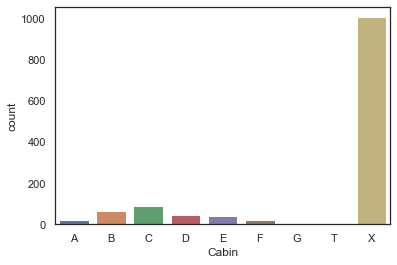

In [66]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

Text(8.96, 0.5, 'Survival Probability')

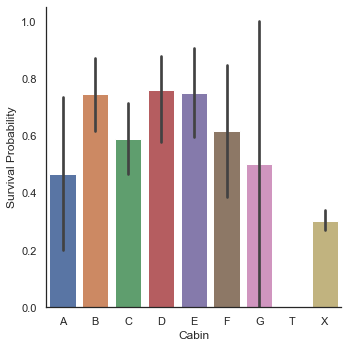

In [67]:
sns.factorplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
plt.ylabel('Survival Probability')

In [68]:
# because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and
# we cant distinguish between survival probability of passengers in the different desks
# but we can see that passengers with a cabin have generally more chance to survive than passengers without (x)
# its particulary true for cabin b,c,d,e and f

In [69]:
dataset = pd.get_dummies(dataset,columns=['Cabin'],prefix='cabin')

### ticket

In [70]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [71]:
# it could mean that tickets sharing the same prefixes could be booked for cabins placed together.
# it could therefore lead to the actual placement of the cabins within the ship
# tickets with same prefixes may have a similar class and survival
# so i decided to replace the ticket feature column by the ticket prefix. which may be more informative

In [72]:
# treat ticket by extracting the ticket prefix. when there is no prefix it returns X.
ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        ticket.append(i.replace(".","").replace('/','').strip().split(' ')[0]) # take prefix
    else:
        ticket.append('X')
dataset['Ticket'] = ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [73]:
dataset = pd.get_dummies(dataset,columns=['Ticket'],prefix='T')

In [74]:
# create categorical values for pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset,columns = ['Pclass'],prefix='pc')

In [75]:
# drop useless variables
dataset.drop(labels=['PassengerId'],axis=1,inplace=True)

In [76]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,smallf,medf,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,pc_1,pc_2,pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [77]:
## separate train dataset and test dataset

train = dataset[:train_len]
test  = dataset[train_len:]
test.drop(labels='Survived',axis=1,inplace=True)

In [78]:
# separate train features and label
train['Survived'] = train['Survived'].astype(int)
y_train = train['Survived']
x_train = train.drop(['Survived'],axis=1)

## simple modeling

### cross validate models

In [80]:
# cross validate model with kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [81]:
# modeling step test differents algorithms
random_state=2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

<AxesSubplot:xlabel='crossval_means', ylabel='algorithms'>

Text(0.5, 0, 'Mean Acc')

Text(0.5, 1.0, 'Cross Val Score')

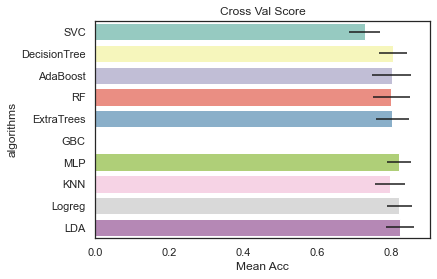

In [146]:
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,x_train,y_train,scoring='accuracy',cv=kfold,n_jobs=4))
    
cv_means = []
cv_std   = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'crossval_means':cv_means,
                       'crossval_error':cv_std,
                       'algorithms'    :['SVC','DecisionTree','AdaBoost','RF','ExtraTrees',
                                         'GBC','MLP','KNN','Logreg','LDA']})

sns.barplot('crossval_means','algorithms',data=cv_res,palette='Set3',orient='h',**{'xerr':cv_std})
plt.xlabel('Mean Acc')
plt.title('Cross Val Score')

### hyperparameter tunning for best models

In [87]:
# meta modeling with adaboost, rf, extratrees and gradientboosting
# adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC,random_state=7)

ada_param_grid = {'base_estimator__criterion' : ['gini','entropy'],
                  'base_estimator__splitter' : ['best','random'],
                  'algorithm' : ['SAMME','SAMME.R'],
                  'n_estimators' : [1,2],
                  'learning_rate' : [0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gsadaDTC.fit(x_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:   12.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=7),
             n_jobs=4,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,
                                           1.5],
                         'n_estimators': [1, 2]},
             scoring='accuracy', verbose=1)

In [88]:
gsadaDTC.best_score_

0.8241317671092953

In [89]:
# extratrees
extc = ExtraTreesClassifier()

## search grid for optimal parameters
ex_param_grid = {'max_depth' : [None],
                 'max_features' : [1,3,10],
                 'min_samples_split' : [2,3,10],
                 'min_samples_leaf' : [1,3,10],
                 'bootstrap' : [False],
                 'n_estimators' : [100,300],
                 'criterion' : ['gini']}

gsextc = GridSearchCV(extc,param_grid = ex_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gsextc.fit(x_train,y_train)

extc_best = gsextc.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   54.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=ExtraTreesClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [90]:
gsextc.best_score_

0.8308605720122575

In [103]:
# rfc parameters tunning
rfc = RandomForestClassifier()

# search grid for optimal parameters
rf_param_grid = {'max_depth' : [None],
                 'max_features' : [1,3,10],
                 'min_samples_split' : [2,3,10],
                 'min_samples_leaf' : [1,3,10],
                 'bootstrap' : [False],
                 'n_estimators' : [100,300],
                 'criterion' : ['gini']}

gsrfc = GridSearchCV(rfc,rf_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gsrfc.fit(x_train,y_train)

gsrfc_best = gsrfc.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   50.6s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  1.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [None], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'min_samples_split': [2, 3, 10],
                         'n_estimators': [100, 300]},
             scoring='accuracy', verbose=1)

In [92]:
gsrfc.best_score_

0.8342824310520939

In [93]:
# gradient boosting tuning
gbc = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['deviance'],
                 'n_estimators' : [100,200,300],
                 'learning_rate' : [0.1,0.05,0.01],
                 'max_depth' : [4,8],
                 'min_samples_leaf' : [100,150],
                 'max_features' : [0.3,0.1]}

gsgbc = GridSearchCV(gbc,gb_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gsgbc.fit(x_train,y_train)

gbc_best = gsgbc.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   18.8s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   35.4s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'loss': ['deviance'], 'max_depth': [4, 8],
                         'max_features': [0.3, 0.1],
                         'min_samples_leaf': [100, 150],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [94]:
gsgbc.best_score_

0.8297497446373852

In [95]:
# svc classifier
svmc = SVC(probability=True)
svc_param_grid = {'kernel' : ['rbf'],
                  'gamma'  : [0.001,0.01,0.1,1],
                  'C' : [1,10,50,100,200,300,1000]}

gssvmc = GridSearchCV(svmc,svc_param_grid,cv=kfold,scoring='accuracy',n_jobs=4,verbose=1)
gssvmc.fit(x_train,y_train)

svmc_best = gssvmc.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   36.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(probability=True), n_jobs=4,
             param_grid={'C': [1, 10, 50, 100, 200, 300, 1000],
                         'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},
             scoring='accuracy', verbose=1)

In [96]:
gssvmc.best_score_

0.8331332992849847

In [101]:
def plot_learning_curve(estimator,title,x,y,ylim=None,cv=None,n_jobs=-1,train_sizes=np.linspace(.1,1.0,5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel('training examples')
    plt.ylabel('score')
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std  = np.std(train_scores,axis=1)
    test_scores_mean  = np.mean(test_scores,axis=1)
    test_scores_std   = np.std(test_scores,axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.1,color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1,color='g')
    plt.plot(train_sizes, train_scores_mean,'o-',color='r',label='training score')
    plt.plot(train_sizes, test_scores_mean,'o-',color='g',label='cv score')
    
    plt.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\rsh15\\anaconda3\\envs\\simon_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\rsh15\\anaconda3\\envs\\simon_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\rsh15\\anaconda3\\envs\\simon_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\rsh15\\anaconda3\\envs\\simon_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

<module 'matplotlib.pyplot' from 'C:\\Users\\rsh15\\anaconda3\\envs\\simon_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

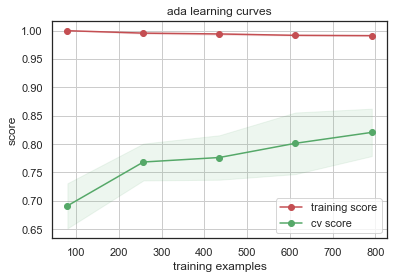

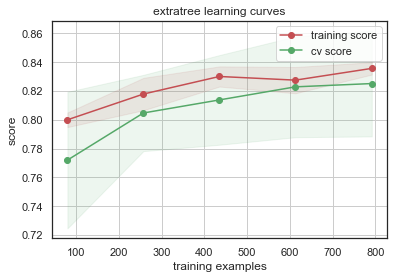

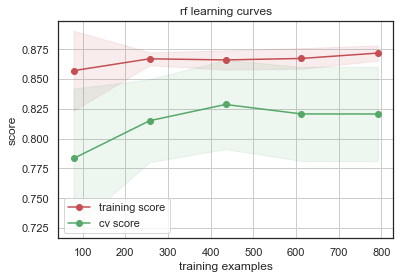

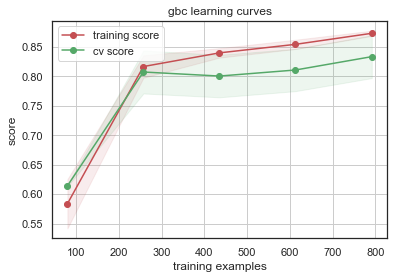

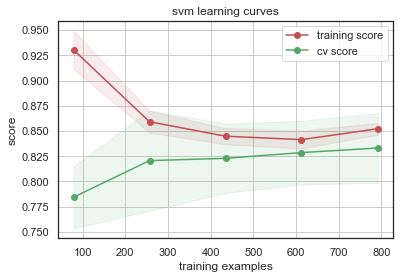

In [104]:
plot_learning_curve(ada_best,'ada learning curves',x_train,y_train,cv=kfold)
plot_learning_curve(extc_best,'extratree learning curves',x_train,y_train,cv=kfold)
plot_learning_curve(gsrfc_best,'rf learning curves',x_train,y_train,cv=kfold)
plot_learning_curve(gbc_best,'gbc learning curves',x_train,y_train,cv=kfold)
plot_learning_curve(svmc_best,'svm learning curves',x_train,y_train,cv=kfold)

Text(0.5, 0, 'relative importance')

Text(0, 0.5, 'features')

Text(0.5, 1.0, 'AdaBoost feature importance')

Text(0.5, 0, 'relative importance')

Text(0, 0.5, 'features')

Text(0.5, 1.0, 'ExtraTrees feature importance')

Text(0.5, 0, 'relative importance')

Text(0, 0.5, 'features')

Text(0.5, 1.0, 'RF feature importance')

Text(0.5, 0, 'relative importance')

Text(0, 0.5, 'features')

Text(0.5, 1.0, 'GBC feature importance')

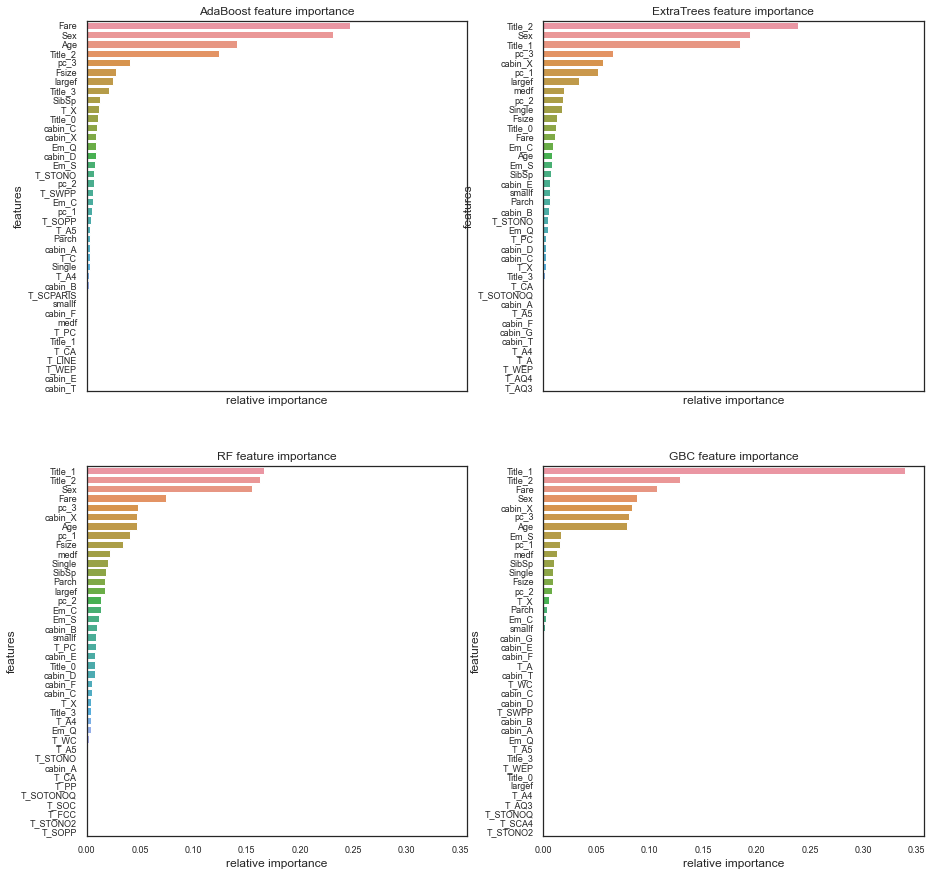

In [110]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows = nrows,ncols = ncols,sharex = 'all',figsize = (15,15))

name_classifiers = [('AdaBoost',ada_best),('ExtraTrees',extc_best),('RF',gsrfc_best),('GBC',gbc_best)]

n_classifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = name_classifiers[n_classifier][0]
        classifier = name_classifiers[n_classifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=x_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40],
                        orient='h',ax=axes[row][col])
        g.set_xlabel('relative importance',fontsize=12)
        g.set_ylabel('features',fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' feature importance')
        n_classifier += 1

In [111]:
gsadaDTC
gsextc
gsrfc
gsgbc
gssvmc

[('AdaBoost',
  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                     learning_rate=0.3, n_estimators=2, random_state=7)),
 ('ExtraTrees',
  ExtraTreesClassifier(max_features=10, min_samples_leaf=10, min_samples_split=10)),
 ('RF',
  RandomForestClassifier(bootstrap=False, max_features=3, min_samples_leaf=3,
                         n_estimators=300)),
 ('GBC',
  GradientBoostingClassifier(max_depth=8, max_features=0.3, min_samples_leaf=100,
                             n_estimators=300))]

In [113]:
test_survived_rf   = pd.Series(gsrfc_best.predict(test),name='RFC')
test_survived_extc = pd.Series(extc_best.predict(test),name='Extc')
test_survived_svmc = pd.Series(svmc_best.predict(test),name='SVM')
test_survived_ada  = pd.Series(ada_best.predict(test),name='Ada')
test_survived_gbc  = pd.Series(gbc_best.predict(test),name='GBC')

In [117]:
ensemble_results = pd.concat([test_survived_rf,test_survived_extc,test_survived_svmc,test_survived_ada,test_survived_gbc],axis=1)

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

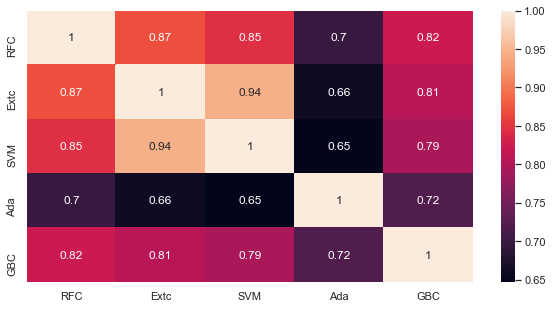

In [121]:
plt.figure(figsize=(10,5))
sns.heatmap(ensemble_results.corr(),annot=True)

## ensemble

In [123]:
votingc = VotingClassifier([('rfc',gsrfc_best),
                            ('extc',extc_best),
                            ('svm',svmc_best),
                            ('ada',ada_best),
                            ('gbc',gbc_best)])
votingc = votingc.fit(x_train,y_train)

In [124]:
votingc

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3,
                                                     n_estimators=300)),
                             ('extc',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=10,
                                                   min_samples_split=10)),
                             ('svm', SVC(C=10, gamma=0.01, probability=True)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                                                 learning_rate=0.3,
                                                 n_estimators=2,
                                                 random_state=7)),
